In [1]:
%matplotlib notebook

In [2]:
import os
import sys
from collections import namedtuple

In [3]:
import numpy as np

In [39]:
import imageio
import moviepy.editor as mp
from IPython.display import HTML

In [5]:
import matplotlib.pyplot as plt
from matplotlib import animation, rc, ticker
from mpl_toolkits.mplot3d.axes3d import Axes3D
plt.ioff()

In [6]:
import seaborn as sns
sns.set()

In [7]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [8]:
from data.analysis_tools import PolynomialRegression

## Data Preparation

The data is stored in $D$ in the form $D[run][visdepth][timestep][\alpha][\beta] = performance$

where:

$\alpha = 10 \times \mbox{learning rate} $

$\beta = 10 \times \mbox{discount rate} $

Note that $D$ is automatically averaged over runs

In [9]:
num_runs = 10
max_vis_depth = 4
num_steps = 10
n = 11

In [10]:
step_size = 10
num_features = max_vis_depth * num_steps * n * n

### Loading

In [11]:
D = np.zeros((max_vis_depth + 1, num_steps + 1, n, n))

In [12]:
for run in range(1, num_runs + 1):
    for depth in range(1, max_vis_depth + 1):
        dir_input = "raw/cat_mouse/depth" + str(depth) + "/run" + str(run) + ".txt"
        with open(os.path.abspath(dir_input)) as f:
            for line in f.readlines():
                line = list(map(int, line.split()))
                a = line[0]
                b = line[1]
                for i in range(2, num_steps + 2):
                    step = i - 1
                    perf = line[i]
                    D[depth][step][a][b] += perf / num_runs

### Preparation of Improvement Tables

In [13]:
ArrayStats = namedtuple('ArrayStats', 'min ave max range')
def get_stats(X):
    xmin = np.amin(X)
    xmax = np.amax(X)
    return ArrayStats(xmin, sum(X.flatten()) / X.size, xmax, xmax - xmin)

#### Calculation

In [14]:
I = np.zeros((max_vis_depth + 1, num_steps + 1, n, n))

In [15]:
for depth in range(1, max_vis_depth + 1):
    for step in range(1, num_steps + 1):
        I[depth][step] = (D[depth][step] - D[depth][step - 1]) / step_size

In [16]:
i_stats = get_stats(I[1:max_vis_depth + 1, 1:num_steps + 1])
i_stats

ArrayStats(min=21.569999999999983, ave=72.748915289256175, max=208.19000000000005, range=186.62000000000006)

#### Normalization

In [17]:
def normalize(X, stats):
    return (stats.range - (X - stats.min)) / stats.range

In [18]:
I_norm = normalize(I, i_stats)

In [19]:
i_norm_stats = get_stats(I_norm[1:max_vis_depth + 1, 1:num_steps + 1])
i_norm_stats

ArrayStats(min=0.0, ave=0.72575867919163961, max=1.0, range=1.0)

### Preparation of Mesh Grids

In [20]:
def_depth = 1
def_step = 10

In [21]:
X_domain = np.linspace(0, 1, n)
X = np.zeros((4, n, n))
X[0] = np.full((n, n), def_depth)
X[1] = np.full((n, n), def_step * step_size)
X[2], X[3] = np.meshgrid(X_domain, X_domain)

In [22]:
Y = I_norm[def_depth][def_step]

In [23]:
y_stats = get_stats(Y)
y_stats

ArrayStats(min=0.40365448504983481, ave=0.79049219211532529, max=1.0, range=0.59634551495016519)

## Data Visualization

In [40]:
def gif_to_mp4(file):
    clip = mp.VideoFileClip("%s.gif" % file)
    clip.write_videofile("%s.mp4" % file)

### Performance Distribution

In [30]:
def plot_dist(X, figsize=(3, 3), load_only=False):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    ax = sns.distplot(X, hist=False, color="b", kde_kws={"shade": True}, ax=ax)
    
    # sns.despine(left=True, ax=ax)
    ax.set_yticks([])
    
    plt.tight_layout()
    plt.savefig("plots/normed_perf_dist.jpeg", transparent=True)
    
    plt.close()
    
    return HTML('<img src="plots/normed_perf_dist.jpeg">')

In [31]:
dist = plot_dist(I_norm[1:max_vis_depth + 1, 1:num_steps + 1].flatten(), figsize=(3, 3))

In [32]:
dist

In [33]:
vmin=0.5
vmax=1.0

### Performance vs. Depth and Time Heatmap

In [28]:
def heatmap_anim_preprocess():
    for step in range(1, num_steps + 1):
        fig, axes = plt.subplots(2, 3, figsize=(6.3, 6), gridspec_kw={'width_ratios':[1, 1, 0.1], 'height_ratios':[1, 1]})

        for i in range(2):
            for j in range(2):
                ax = sns.heatmap(I_norm[2*i + j + 1][step],
                                 vmin=vmin, vmax=vmax,
                                 cmap=sns.color_palette("Blues", n_colors=100),
                                 ax=axes[i][j],
                                 cbar=False)

                if i == 1:
                    ax.set_xticks(np.linspace(0, 10, 6) + .5)
                    ax.set_xticklabels(np.linspace(0, 1, 6))
                else:
                    ax.set_xticks([])

                if j == 0:
                    ax.set_yticks(np.linspace(0, 10, 6) + 0.8)
                    ax.set_yticklabels(np.linspace(0, 1, 6))
                else:
                    ax.set_yticks([])

                ax.set_xlabel('')
                ax.set_ylabel('')

                ax.invert_yaxis()

        mappable = axes[0][0].get_children()[0]
        plt.colorbar(mappable, ax=axes, orientation='vertical', ticks=[], cax=axes[0][2], extend='max');
        plt.colorbar(mappable, ax=axes, orientation='vertical', ticks=[], cax=axes[1][2], extend='max');

        plt.tight_layout()
        plt.savefig("plots/depth_heatmap/frame%d.jpeg" % step, transparent=True)
        plt.close()

In [36]:
def heatmap_animate(load_only=False, fps=1, vid=True):
    images = []
    for step in range(1, num_steps + 1):
        images.append(imageio.imread("plots/depth_heatmap/frame%d.jpeg" % step))
    imageio.mimsave("plots/depth_heatmap/anim.gif", images, fps=fps)
    
    gif_to_mp4('plots/depth_heatmap/anim')
    
    if vid:
        return HTML('<video controls> <source src="plots/depth_heatmap/anim.mp4" type="video/mp4"> </video>')
    else:
        return HTML('<img src="plots/depth_heatmap/anim.gif">')

In [30]:
heatmap_anim_preprocess()

In [41]:
heatmap_vid = heatmap_animate()

[MoviePy] >>>> Building video plots/depth_heatmap/anim.mp4
[MoviePy] Writing video plots/depth_heatmap/anim.mp4


 91%|██████████████████████████████████████▏   | 10/11 [00:00<00:00, 59.88it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: plots/depth_heatmap/anim.mp4 



In [42]:
heatmap_vid

### Regression

In [33]:
model = PolynomialRegression(X, Y)

#### Linear model

In [34]:
lin_model = model.process(degree=1)
lin_model.print_func()

0.000091*1 + 0.000091*x0 + 0.009132*x1 + -0.056874*x2 + -0.188991*x3


In [35]:
print(lin_model.r_squared)

0.235152011463


#### Quadratic model

In [36]:
quad_model = model.process(degree=2)
quad_model.print_func()

0.000000*1 + 0.000000*x0 + 0.000001*x1 + 0.000044*x2 + 0.000057*x3 + 0.000000*x0^2 + 0.000001*x0*x1 + 0.000044*x0*x2 + 0.000057*x0*x3 + 0.000074*x1^2 + 0.004428*x1*x2 + 0.005738*x1*x3 + -0.604418*x2^2 + 0.209299*x2*x3 + -0.867604*x3^2


In [37]:
print(quad_model.r_squared)

0.78807150507


#### Cubic model

In [38]:
cube_model = model.process(degree=3)
cube_model.print_func()

0.000000*1 + 0.000000*x0 + 0.000000*x1 + 0.000000*x2 + 0.000000*x3 + 0.000000*x0^2 + 0.000000*x0*x1 + 0.000000*x0*x2 + 0.000000*x0*x3 + 0.000000*x1^2 + 0.000000*x1*x2 + 0.000001*x1*x3 + -0.000040*x2^2 + 0.000051*x2*x3 + -0.000137*x3^2 + 0.000000*x0^3 + 0.000000*x0^2*x1 + 0.000000*x0^2*x2 + 0.000000*x0^2*x3 + 0.000000*x0*x1^2 + 0.000000*x0*x1*x2 + 0.000001*x0*x1*x3 + -0.000040*x0*x2^2 + 0.000051*x0*x2*x3 + -0.000137*x0*x3^2 + 0.000001*x1^3 + 0.000026*x1^2*x2 + 0.000074*x1^2*x3 + -0.004047*x1*x2^2 + 0.005088*x1*x2*x3 + -0.013665*x1*x3^2 + 0.002643*x2^3 + -0.407209*x2^2*x3 + 0.107606*x2*x3^2 + 0.296936*x3^3


In [39]:
print(cube_model.r_squared)

0.799414450235


### 3D Plotting

In [40]:
def plot_3d(model, degree):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    
    p = model.plot(ax, idx=(2, 3), Z=Y, plot_type='wireframe', show_contours=False)
    q = model.plot(ax, idx=(2, 3), Z=model.process(degree=degree).predict(), 
                   lims=((0.0, 1.5), (0.0, 1.5), (0, 1)),
                   show_labels=True, labels=("Learning Rate", "Discount Rate", "Agent Performance"))

    # formatter = ticker.ScalarFormatter(useMathText=True)
    # formatter.set_scientific(True) 
    # formatter.set_powerlimits((-1,1)) 
    # ax.zaxis.set_major_formatter(formatter)

    ax.set_xticks(np.linspace(0, 1, 6))
    ax.set_yticks(np.linspace(0, 1, 6))
    ax.set_zticks([0.0, 1.0])
    ax.set_zticklabels(['low', 'high'])
    
    ax.invert_xaxis()
    # ax.invert_yaxis()
    # ax.invert_zaxis()
    
    fig.patch.set_alpha(0.)
    ax.patch.set_alpha(0.0)
    ax.grid(False)
    
    return ax

In [41]:
def plot_animate_preprocess(model, degree):
    ax = plot_3d(model, degree)
    
    for ii in range(0, 360, 1):
        ax.view_init(elev=30., azim=ii)
        plt.savefig("plots/regression/degree%d/frame%d.jpeg" % (degree, ii), transparent=True)
    
    plt.close()

In [42]:
def plot_animate_beta(degree, secs=6, fps=60):
    frame_steps = 360 // (secs * fps)
    
    images = []
    for ii in range(0, 360, frame_steps):
        images.append(imageio.imread("plots/regression/degree%d/frame%d.jpeg" % (degree,ii)))
    imageio.mimsave("plots/regression/degree%d/anim%d.gif" % (degree, fps), images, fps=60)
    
    return HTML('<img src="plots/regression/degree%d/anim%d.gif">' % (degree, fps))

In [43]:
print(model.X[3])

[[ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1]
 [ 0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2]
 [ 0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3]
 [ 0.4  0.4  0.4  0.4  0.4  0.4  0.4  0.4  0.4  0.4  0.4]
 [ 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5]
 [ 0.6  0.6  0.6  0.6  0.6  0.6  0.6  0.6  0.6  0.6  0.6]
 [ 0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7]
 [ 0.8  0.8  0.8  0.8  0.8  0.8  0.8  0.8  0.8  0.8  0.8]
 [ 0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9]
 [ 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1. ]]


In [47]:
ax = plot_3d(model, degree=1)

In [49]:
ax

<IPython.core.display.Javascript object>


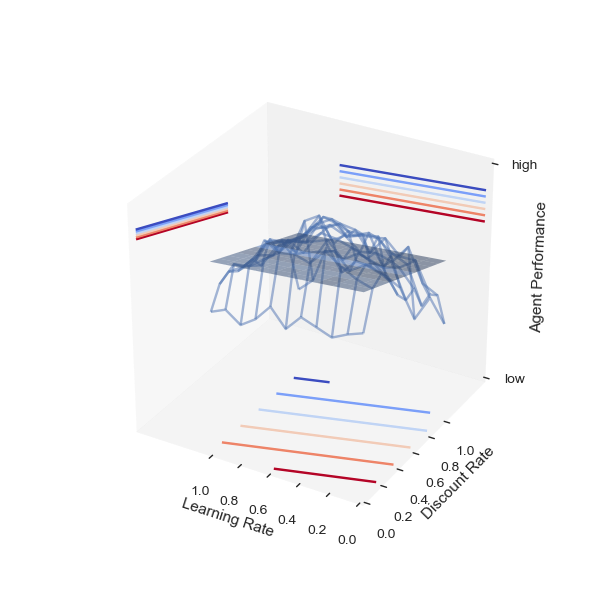

In [48]:
plt.show()

#### Linear Estimate

In [42]:
plot_animate_preprocess(model, degree=1)

In [43]:
anim1 = plot_animate_beta(degree=1, secs=6, fps=60)

In [44]:
HTML('<img src="plots/regression/degree1/anim60_compressed.gif">')

#### Quadratic Estimate

In [45]:
plot_animate_preprocess(model, degree=2)

In [46]:
anim2 = plot_animate_beta(degree=2, secs=6, fps=60)

In [47]:
HTML('<img src="plots/regression/degree2/anim60_compressed.gif">')

#### Cubic Estimate

In [48]:
plot_animate_preprocess(model, degree=3)

In [49]:
anim3 = plot_animate_beta(degree=3, secs=6, fps=60)

In [50]:
HTML('<img src="plots/regression/degree3/anim60_compressed.gif">')